In [1]:
import pandas as pd
import numpy as np
from common import utils
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time
import re
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
import string
%matplotlib inline

os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

#load training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')


## Implement baseline - SVM with n-gram features as per the original paper

In [2]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [3]:
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [4]:
twitter_test.shape

(1956, 5)

In [5]:
### preprocessor for my first iteration
#def preprocess_tweets(x):
#    """Create preprocessor to retain @, !, #, ? when leveraging CountVectorizer to create word n-grams;
#    These characters are likely important to capturing stance given nature of a tweet"""
#    
#    tokens = x.replace("@"," ATSIGN ").replace("!"," XPT ").replace("#"," HASHTAG ").replace("?"," QUESTM ")
#    tokens = re.sub("\d+", "DIGIT", tokens)
#    return tokens

In [6]:
def preprocess_tweets(x):
    """Create preprocessor to retain @, !, #, ? when leveraging CountVectorizer to create word n-grams;
    These characters are likely important to capturing stance given nature of a tweet"""
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    #add token for digits, at sign, and hashtags
    tokens = x_lower.replace("@","ATSIG").replace("#","HASH")
    tokens2 = re.sub("\d+", "DIGIT", tokens)
    
    #remove whitespace
    tokens3 = ' '.join(tokens2.split())
    
    return tokens3

print("Raw: " + str(twitter_train['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: ATSIGtedcruz and HASHhandovertheserver she wiped clean DIGITk deleted emails explains dereliction of dutylies re HASHbenghazietc HASHtcot


In [7]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [10]:
def svm_stance(train, test, topic_list):
    """This function takes a list of topics and returns the stance classification f1 score
    of our baseline SVM implementation over the training / test data filtered for the applicable topics"""
    
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #carve out tweets
    tweets_train = twitter_train[matches_train]['Tweet']
    tweets_test = twitter_test[matches_test]['Tweet']

    #convert stance to labels for feeding sklearn SVM
    stance_labels_train = np.array(twitter_train[matches_train]['Stance'].apply(lambda x: 
                                                                                2 if x == "FAVOR" else 
                                                                                (1 if x == "NONE" else 0)))

    stance_labels_test = np.array(twitter_test[matches_test]['Stance'].apply(lambda x: 
                                                                             2 if x == "FAVOR" else 
                                                                             (1 if x == "NONE" else 0)))

    
    #pass tweets through pre-processor before feeding to CountVectorizer for word n-gram features
    preprocess_train = tweets_train.apply(lambda x: preprocess_tweets(x))
    preprocess_test = tweets_test.apply(lambda x: preprocess_tweets(x))
    
    #convert training data to sparse matrix for n-gram words
    word_grams = CountVectorizer(ngram_range = (1,3))
    train_nwords = word_grams.fit_transform(preprocess_train)
    
    #convert test data to sparse matrix for n-gram words
    test_nwords = word_grams.transform(preprocess_test)
    
    #convert training data to sparse matrix for n-gram chars
    char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
    train_nchars = char_grams.fit_transform(tweets_train)
    
    #convert test data to sparse matrix for n-gram chars
    test_nchars = char_grams.transform(tweets_test)
    
    #stack the word and char n-grams
    train_grams = hstack((train_nwords, train_nchars))
    test_grams = hstack((test_nwords, test_nchars))
    
    ##<<WE MAY WANT TO CONSIDER LEAVING OUT THE BELOW COMMENTED OUT CODE IT REALLY SLOWS IT DOWN
    ##F1 SCORES ARE ALSO HIGHER WHEN WE DO NOT LEAVE IT IN THERE>>
    
    #turn counts into presence/absence indicators, as mentioned in the paper
    #train_grams = pd.DataFrame(train_grams.todense())
    #test_grams = pd.DataFrame(test_grams.todense())
    
    #train_grams = train_grams.applymap(lambda x: 1 if x > 1 else x)
    #test_grams = test_grams.applymap(lambda x: 1 if x > 1 else x)
    
    #train_grams = csr_matrix(train_grams.values)
    #test_grams = csr_matrix(test_grams.values)
    
    #Gridserach for tuning hyperparameters (C and class weights)
    #param_grid = {'C':[0.001, 0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 10, 100]}
    
    #svm_grid = SVC(kernel = 'linear')
    
    #grid = GridSearchCV(estimator=svm_grid, param_grid=param_grid, cv = 5, n_jobs = -1, verbose = 2)
    #grid.fit(train_grams, stance_labels_train)
    
    #print("Best Hyperparameters:")
    #print(grid.best_params_)
    
    
    #train SVM
    start_time_train = time.time()
    #svm = SVC(kernel = 'linear', C = grid.best_params_['C'])
    svm = SVC(kernel = 'linear')
    svm.fit(train_grams,stance_labels_train)
    end_time_train = time.time()
    print("Training time:",end_time_train - start_time_train)

    #prediction
    start_time_predict = time.time()
    stance_predict = svm.predict(test_grams)
    end_time_predict = time.time()
    print("Prediction time:", end_time_predict - start_time_predict)

    #calculate f1 score
    #f1 = f1_score(stance_labels_test, stance_predict, average = 'macro')
    class_report_dict = classification_report(y_true = stance_labels_test, 
                                        y_pred = stance_predict,
                                        target_names = ['Against', 'None', 'Favor'], output_dict=True)
    
    f1 = (class_report_dict['Favor']['f1-score'] + class_report_dict['Against']['f1-score']) / 2
    
    
    report = classification_report(y_true = stance_labels_test, 
                                        y_pred = stance_predict,
                                        target_names = ['Against', 'None', 'Favor'])
    
    confuse = confusion_matrix(y_true = stance_labels_test, y_pred = stance_predict) 
    
    return f1, report, confuse

Training time: 0.6845710277557373
Prediction time: 0.18689799308776855
F1 score for atheism (favor and against only): 0.6216931216931217
              precision    recall  f1-score   support

     Against       0.80      0.82      0.81       160
        None       0.44      0.50      0.47        28
       Favor       0.50      0.38      0.43        32

   micro avg       0.72      0.72      0.72       220
   macro avg       0.58      0.57      0.57       220
weighted avg       0.71      0.72      0.71       220



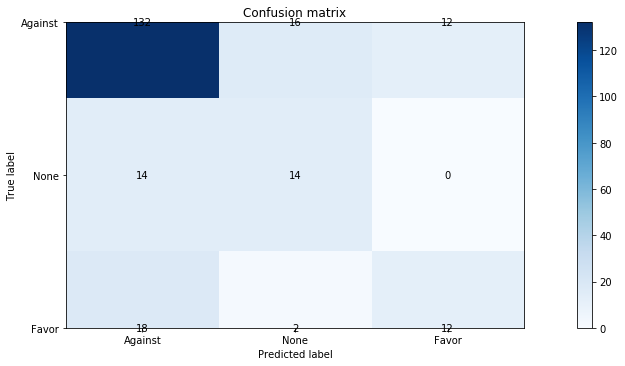

In [11]:
#Atheism
f1_ath, report_ath, confuse_ath = svm_stance(twitter_train, twitter_test, ['Atheism'])
print("F1 score for atheism (favor and against only):", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 1.1412630081176758
Prediction time: 0.33167219161987305
F1 score for Hillary (favor and against only) 0.6060329792294277
              precision    recall  f1-score   support

     Against       0.72      0.83      0.77       172
        None       0.68      0.64      0.66        78
       Favor       0.65      0.33      0.44        45

   micro avg       0.71      0.71      0.71       295
   macro avg       0.69      0.60      0.62       295
weighted avg       0.70      0.71      0.69       295



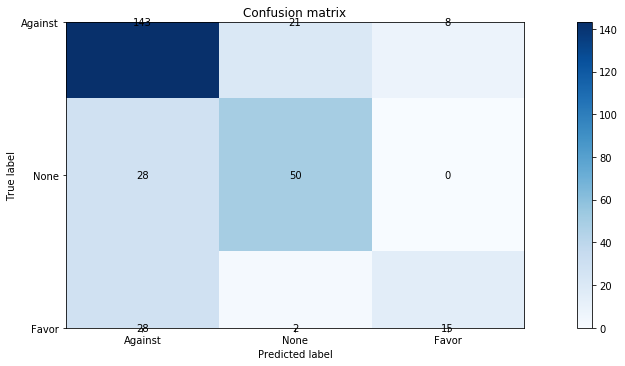

In [12]:
#Hillary
f1_hil, report_hil, confuse_hil = svm_stance(twitter_train, twitter_test, ['Hillary Clinton'])
print("F1 score for Hillary (favor and against only)", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 1.0418908596038818
Prediction time: 0.3012351989746094
F1 score for Abortion (favor and against only) 0.6337555228276878
              precision    recall  f1-score   support

     Against       0.80      0.68      0.73       189
        None       0.35      0.53      0.42        45
       Favor       0.51      0.57      0.54        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.55      0.59      0.56       280
weighted avg       0.68      0.64      0.65       280



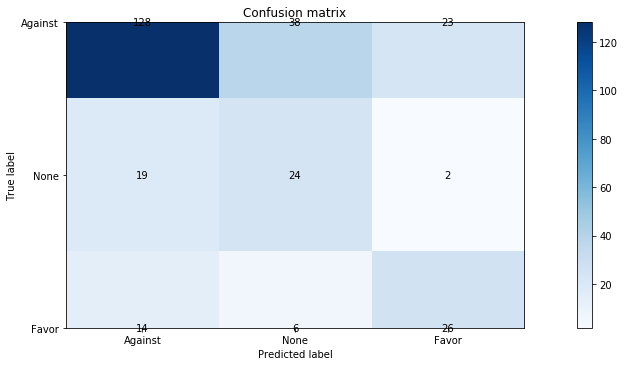

In [13]:
#Abortion
f1_abort, report_abort, confuse_abort = svm_stance(twitter_train, twitter_test, ['Legalization of Abortion'])
print("F1 score for Abortion (favor and against only)", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.3933892250061035
Prediction time: 0.10766410827636719
F1 score for climate change (favor and against only) 0.41796875
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.47      0.49      0.48        35
       Favor       0.80      0.87      0.84       123

   micro avg       0.73      0.73      0.73       169
   macro avg       0.43      0.45      0.44       169
weighted avg       0.68      0.73      0.71       169



/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


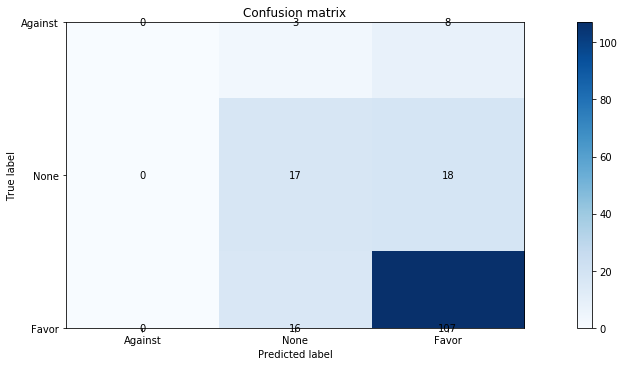

In [14]:
#Climate
f1_clim, report_clim, confuse_clim = svm_stance(twitter_train, twitter_test, ['Climate Change is a Real Concern'])
print("F1 score for climate change (favor and against only)", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 1.1275761127471924
Prediction time: 0.32618212699890137
F1 score for feminist mov (favor and against only) 0.5969898662829045
              precision    recall  f1-score   support

     Against       0.79      0.62      0.70       183
        None       0.50      0.52      0.51        44
       Favor       0.40      0.66      0.50        58

   micro avg       0.61      0.61      0.61       285
   macro avg       0.56      0.60      0.57       285
weighted avg       0.67      0.61      0.63       285



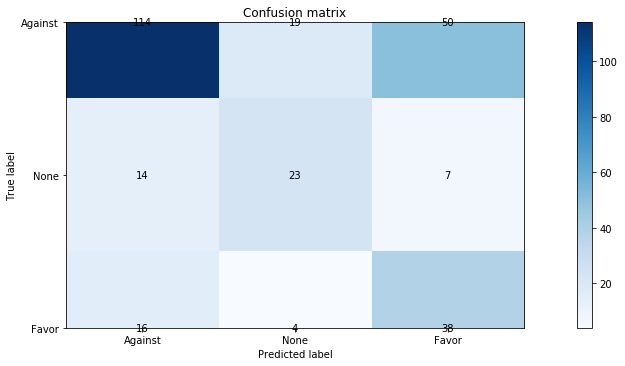

In [15]:
#Feminism
f1_fem, report_fem, confuse_fem = svm_stance(twitter_train, twitter_test, ['Feminist Movement'])
print("F1 score for feminist mov (favor and against only)", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 20.71554207801819
Prediction time: 6.049026012420654
F1 score for all topics (favor and against only) 0.6144031082065132
              precision    recall  f1-score   support

     Against       0.73      0.68      0.70       715
        None       0.51      0.57      0.54       230
       Favor       0.51      0.54      0.53       304

   micro avg       0.63      0.63      0.63      1249
   macro avg       0.58      0.60      0.59      1249
weighted avg       0.64      0.63      0.63      1249



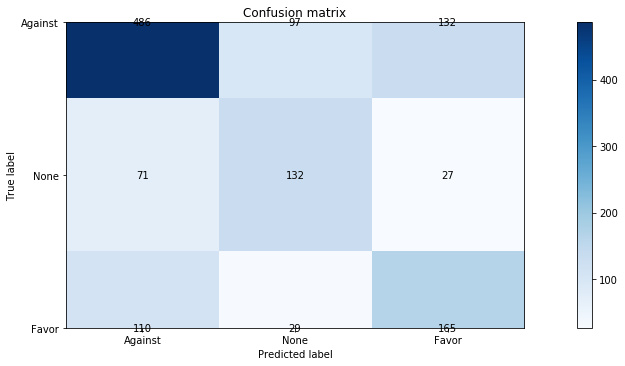

In [16]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = svm_stance(twitter_train, twitter_test, all_tops)
print("F1 score for all topics (favor and against only)", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()